# Topic Modeling with Dynamic Topic Model #

We have used Dynamic Topic Model (https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf)
to capture the time evolution of topics in the COVID-19 Open Research Dataset. We also plot the dynamics of
research volume of various topics over time.

## Aproach
1. Loading the paper abstacts
2. Tokenizing and cleaning data texts
3. Training a Dynamic Topic Model on the cleaned data
4. Identifying the topics and plotting the volume

## Loading Data

In [1]:
import os
print(os.listdir("./input"))

['metadata.csv.zip']


In [2]:
# https://www.kaggle.com/jieyang0311/covid-19-topic-modeling-lda
# load library
import os
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

In [3]:
# Load the metadata.csv
meta = pd.read_csv("input/metadata.csv")
print(meta.shape)

(57366, 18)


In [4]:
# First filter the meta file. Select only papers between 1st January and 31st March
meta["publish_time"] = pd.to_datetime(meta["publish_time"])
meta["publish_year"] = (pd.DatetimeIndex(meta['publish_time']).year)
meta["publish_month"] = (pd.DatetimeIndex(meta['publish_time']).month)
meta["publish_day"] = (pd.DatetimeIndex(meta['publish_time']).day)
meta = meta[meta["publish_year"] == 2020]
meta = meta[meta["publish_month"] <= 3]
print(meta.shape[0], " papers are available between 2020 Jan 1 and 2020 March 31.")

4241  papers are available between 2020 Jan 1 and 2020 March 31.


In [5]:
# Sort the meta using publish time
meta = meta.sort_values(["publish_time"]);
meta[-3:]

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,publish_year,publish_month,publish_day
46584,g6ynt0f9,f06ef04db2928aa8b627475a04a65d227ea97c1a; f06e...,Elsevier,Proprotein convertases: Key players in inflamm...,10.1016/j.canlet.2019.12.027,PMC7115805,31899298.0,els-covid,Abstract Many cancers occur from locations of ...,2020-03-31,...,Cancer Letters,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/j.canlet.2019.12.027,2020.0,3.0,31.0
36314,bzq1xxqb,25c7476e1d441463f442ce3f5c157ee699ddc70a,biorxiv,Lectin-like Intestinal Defensin Inhibits 2019-...,10.1101/2020.03.29.013490,NaN,NaN,biorxiv,The burgeoning epidemic caused by novel corona...,2020-03-31,...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.03.29.013490,2020.0,3.0,31.0
16444,tlpwxtqr,NaN,PMC,Love in the Time of Corona,10.7326/m20-1137,PMC7137101,32227245.0,no-cc,One of the most painful aspects of this pandem...,2020-03-31,...,Ann Intern Med,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,2020.0,3.0,31.0


### Extract the abstract and publish time

In [6]:
#count how many has abstract
count = 0
index = []
for i in range(len(meta)):
    #print(i)
    if type(meta.iloc[i, 8])== float:
        count += 1
    else:
        index.append(i)

print(len(index), " papers have abstract available.")
meta = meta.iloc[index]
len(meta)

3238  papers have abstract available.


3238

In [7]:
##extract the abstract to pandas 
documents = meta.iloc[:, 8]
documents = documents.reset_index()
documents.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
documents["index"] = documents.index.values
documents.head(3)

,abstract,index
0,Objective To investigate the mental health of ...,0
1,"Coronavirus Disease 2019 (COVID-19), caused by...",1
2,SARS-CoV-2 has caused tens of thousands of inf...,2


In [8]:
##extract the publication time to pandas
pub_time = meta.iloc[:, 9]
pub_time = pub_time.reset_index()
pub_time.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
pub_time["index"] = pub_time.index.values
pub_time.head(3)

,publish_time,index
0,2020-01-01,0
1,2020-01-01,1
2,2020-01-01,2


## Preprocessing

### Utils
https://www.kaggle.com/dskswu/topic-modeling-bert-lda

In [19]:
#!pip install stop_words
#!pip install language_detector
!pip install -U symspellpy

  Using cached symspellpy-6.7.6-py3-none-any.whl (2.6 MB)
  Using cached editdistpy-0.1.3.tar.gz (57 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build editdistpy


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [5 lines of output]
  running bdist_wheel
  running build
  running build_ext
  building 'editdistpy.levenshtein' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for editdistpy
ERROR: Could not build wheels for editdistpy, which is required to install pyproject.toml-based projects


In [18]:
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
from language_detector import detect_language

import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


###################################
#### sentence level preprocess ####
###################################

# lowercase + base filter
# some basic normalization
def f_base(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()


# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """

    # some reviews are actually english but biased toward french
    return detect_language(s) in {'English', 'French','Spanish','Chinese'}


###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    #|set(get_stop_words('cy'))
    |set(get_stop_words('pt'))
    #|set(get_stop_words('tl'))
    |set(get_stop_words('pl'))
    #|set(get_stop_words('et'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    #|set(get_stop_words('so'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    #|set(get_stop_words('cs'))
    |set(get_stop_words('nl'))
    #|set(get_stop_words('sl'))
    #|set(get_stop_words('no'))
    #|set(get_stop_words('zh-cn'))
))





def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list


def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100
    if samp_size > len(docs):
        samp_size = len(docs)

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    #     samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size)
    samp.sort()
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in


ModuleNotFoundError: No module named 'symspellpy'

### Preprocess the data

In [27]:
data = documents
data = data.fillna('')
rws = data.abstract
samp_size = 51000
sentences, token_lists, idx_in = preprocess(rws, samp_size=samp_size)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


## Train Dynamic Topic Model
Train dynamic topic model using gensim library

### Create and save the bag-of-word and tf-ifd corpuses

In [28]:
import pickle

dictionary = corpora.Dictionary(token_lists)
bow_corpus = [dictionary.doc2bow(text) for text in token_lists]

tfidf_model = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]

pickle.dump(dictionary, open('dictionary.pkl', 'wb'))
pickle.dump(bow_corpus, open('bow_corpus.pkl', 'wb'))
pickle.dump(tfidf_corpus, open('tfidf_corpus.pkl', 'wb'))

### Train the Model using tf-idf corpus and save it

In [29]:
from gensim.models import LdaSeqModel
import pickle

dictionary = pickle.load(open('dictionary.pkl', 'rb'))
tfidf_corpus = pickle.load(open('tfidf_corpus.pkl', 'rb'))

num_slice = 6
num_topics = 5
num_docs_per_slice = int(len(tfidf_corpus)/num_slice)
time_slice = [num_docs_per_slice for _ in range(num_slice-1)]
time_slice.append(len(tfidf_corpus)-(num_slice-1)*num_docs_per_slice)

ldaseq = LdaSeqModel(corpus=tfidf_corpus, time_slice=time_slice, num_topics=num_topics, id2word=dictionary)
ldaseq.save("ldaseq_tfidf_model_"+str(num_topics)+'_'+str(num_slice))

/opt/conda/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


## Plot Results

### Load the saved model

In [30]:
from gensim.models import LdaSeqModel
ldaseq = LdaSeqModel.load("ldaseq_tfidf_model_5_6")

### Print the top terms of the topics over time

In [62]:
# Observing the evolution of topic distribution

import pandas as pd

def get_topic_dist_time(model, top_terms=10):
    """
    For each topic obtain the top terms in all the time slice
    :param model: the trained LdaSeqModel
    :param top_terms: the number of top terms to be obtained
    :return: the list of panda dataframe containing the top terms
             of all the topics
    """
    
    df_list = []
    for i in range(model.num_topics):
        word_list = []
        for j in range(6):
            words = ldaseq.print_topic(i, j, top_terms=top_terms)
            word_list.append(words)
        keys = ['Jan 01-Jan 15', 'Jan 15-Jan 31', 'Feb 01-Feb 15', \
                'Feb 15-Feb 29', 'Mar 01-Mar 15', 'Mar 15-Jan 31']
        dic = {}
        for i in range(6):
            dic[keys[i]] = []
        for k in range(top_terms):
            for j in range(6):
                w, p = word_list[j][k]
                dic[keys[j]].append(w)
        df_list.append(pd.DataFrame(dic))
    return df_list

df_list = get_topic_dist_time(ldaseq, 15)

In [67]:
print("Topic 1: top 15 terms")
df_list[0]

Topic 1: top 15 terms


,Jan 01-Jan 15,Jan 15-Jan 31,Feb 01-Feb 15,Feb 15-Feb 29,Mar 01-Mar 15,Mar 15-Jan 31
0,cell,cell,cell,cell,protein,protein
1,protein,protein,protein,protein,cell,cell
2,drug,drug,drug,drug,drug,drug
3,vaccin,vaccin,vaccin,vaccin,vaccin,vaccin
4,virus,virus,virus,virus,virus,virus
5,sequenc,sequenc,sequenc,sequenc,viru,sequenc
6,viru,viru,viru,viru,sequenc,viru
7,gene,gene,gene,gene,gene,gene
8,host,host,host,host,host,host
9,receptor,receptor,receptor,receptor,receptor,receptor


In [66]:
print("Topic 2: top 15 terms")
df_list[1]

Topic 2: top 15 terms


,Jan 01-Jan 15,Jan 15-Jan 31,Feb 01-Feb 15,Feb 15-Feb 29,Mar 01-Mar 15,Mar 15-Jan 31
0,case,case,case,case,case,case
1,number,number,number,number,number,number
2,model,model,model,model,model,model
3,transmiss,transmiss,transmiss,transmiss,transmiss,transmiss
4,china,china,china,china,china,china
5,data,data,data,data,countri,countri
6,countri,countri,countri,countri,data,data
7,travel,travel,travel,travel,travel,travel
8,outbreak,outbreak,outbreak,outbreak,outbreak,outbreak
9,day,day,day,day,day,day


In [68]:
print("Topic 3: top 15 terms")
df_list[2]

Topic 3: top 15 terms


,Jan 01-Jan 15,Jan 15-Jan 31,Feb 01-Feb 15,Feb 15-Feb 29,Mar 01-Mar 15,Mar 15-Jan 31
0,health,health,health,health,health,health
1,prevent,prevent,prevent,prevent,prevent,prevent
2,control,control,control,care,care,care
3,patient,patient,patient,control,patient,patient
4,care,care,care,patient,control,control
5,manag,manag,manag,manag,manag,manag
6,emerg,emerg,emerg,emerg,emerg,emerg
7,infect,hospit,hospit,hospit,hospit,hospit
8,hospit,infect,infect,infect,infect,infect
9,diseas,diseas,diseas,diseas,diseas,diseas


In [69]:
print("Topic 4: top 15 terms")
df_list[3]

Topic 4: top 15 terms


,Jan 01-Jan 15,Jan 15-Jan 31,Feb 01-Feb 15,Feb 15-Feb 29,Mar 01-Mar 15,Mar 15-Jan 31
0,mac,mac,mac,mac,mac,mac
1,scientist,scientist,scientist,scientist,scientist,scientist
2,press,press,press,press,press,press
3,access,access,access,access,access,access
4,american,american,american,american,american,american
5,job,job,job,job,job,job
6,carrier,carrier,carrier,carrier,carrier,carrier
7,agglomer,agglomer,agglomer,agglomer,agglomer,agglomer
8,asthma,asthma,asthma,asthma,asthma,asthma
9,mutat,mutat,mutat,mutat,mutat,mutat


In [70]:
print("Topic 5: top 15 terms")
df_list[4]

Topic 5: top 15 terms


,Jan 01-Jan 15,Jan 15-Jan 31,Feb 01-Feb 15,Feb 15-Feb 29,Mar 01-Mar 15,Mar 15-Jan 31
0,patient,patient,patient,patient,patient,patient
1,case,case,case,case,case,case
2,pneumonia,pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
3,treatment,treatment,treatment,treatment,treatment,treatment
4,symptom,symptom,symptom,symptom,symptom,symptom
5,respiratori,respiratori,respiratori,respiratori,respiratori,respiratori
6,test,test,test,test,test,test
7,group,group,group,group,group,group
8,lung,lung,infect,diseas,infect,infect
9,infect,infect,diseas,infect,diseas,diseas


Observing the top terms, we can conclude that the term distributions of all the five topics remain same over the period 
of 1st Jan to 31st March. Based on the top terms of the five topics, we indentify the topics as

* **Topic 1: virology and medicine** (cell, protein, drug, vaccin, virus, sequenc, gene, host, receptor, strain, genom, bat, infect)
* **Topic 2: spreading of the disease** (case, number, model, transmiss, china, data, countri, travel, outbreak, day, measur, citi, rate, wuhan)
* **Topic 3: health care** (health, prevent, care, control, patient, manag, emerg, hospit, infect, diseas, treatment, outbreak, countri, china)
* **Topic 4: impact on society** (mac, scientist, press, access, american, job, carrier, agglomer, asthma, mutat, instrument, hous, best, peptid)
* **Topic 5: disease symptoms** (patient, case, pneumonia, treatment, symptom, respiratori, test, group, diseas, infect, lung, studi, hospit, day)

### Plot changes in the research volume of all the topics over time

In [41]:
# Volume of research on each topic in different time period
# Print the marginal probability of all the topics

import numpy as np

def get_doc_sizes(corpus):
    """
    Computes the size of each documents of the corpus
    :param corpus: the text corpus (bag-of-words or tf-idf)
    :return: the list of document sizes
    """
    doc_sizes = []
    for doc in bow_corpus:
        size = sum([v for k, v in doc])
        doc_sizes.append(size)
    return doc_sizes
    
def get_marginal_topic_dist(docs, doc_sizes, model):
    """
    Computes the marginal probability of a list of the documents 
    :param docs: list of document ids
    :param doc_sizes: the list of sizes of the documents in docs
    :param model: the trained LdaSeqModel model
    :return: the marginal probabilities of documents as list
    """
    prob = np.zeros((model.num_topics))
    for doc in docs:
        prob += np.array(model.doc_topics(doc)) * doc_sizes[doc]
    corpus_size = sum([doc_sizes[d] for d in docs])
    prob /= corpus_size
    return list(prob)

def get_time_slice(num_docs, num_slices):
    """
    Computes the number of documents in each time slice
    :param num_docs: the total number of documents
    :param num_slices: the number of total slices
    :return: the list of the number of documents in each time slice
    """
    num_docs_per_slice = int(num_docs/num_slices)
    time_slice = [num_docs_per_slice for _ in range(num_slices-1)]
    time_slice.append(num_docs-(num_slices-1)*num_docs_per_slice)
    return time_slice
    
ldaseq = LdaSeqModel.load("ldaseq_tfidf_model_5_6")
tfidf_corpus = pickle.load(open('tfidf_corpus.pkl', 'rb'))
doc_sizes = get_doc_sizes(tfidf_corpus)

time_slice = get_time_slice(len(tfidf_corpus), 6)
st_index = 0
marg_dist_list = []
for s in time_slice:
    dist = get_marginal_topic_dist(range(st_index, st_index+s), doc_sizes, ldaseq)
    marg_dist_list.append(dist)
    st_index += s

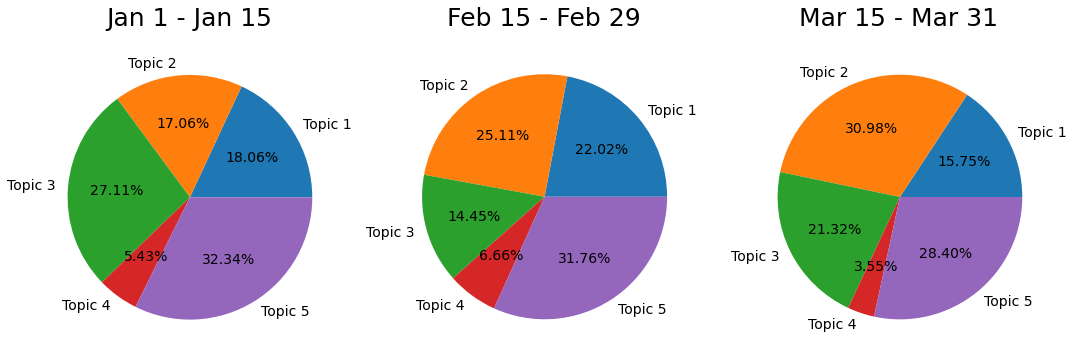

In [74]:
# Plotting the pie chart for the total volume of research in each topic

import matplotlib.pyplot as plt

labels = 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'

# Plots the pie chart for the time slice Jan 1 - Jan 15
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.pie(marg_dist_list[0], labels=labels, autopct='%1.2f%%', textprops={'fontsize': 14})
ax1.axis('equal')
ax1.set_title('Jan 1 - Jan 15', fontsize=25, pad=35)

# Plots the pie chart for the time slice Feb 15 - Feb 29
ax2.pie(marg_dist_list[3], labels=labels, autopct='%1.2f%%', textprops={'fontsize': 14})
ax2.axis('equal')
ax2.set_title('Feb 15 - Feb 29', fontsize=25, pad=35)

# Plots the pie chart for the time slice Mar 15 - Mar 31
ax3.pie(marg_dist_list[5], labels=labels, autopct='%1.2f%%', textprops={'fontsize': 14})
ax3.axis('equal')
ax3.set_title('Mar 15 - Mar 31', fontsize=25, pad=35)

#plt.tight_layout()
plt.show()

Previously, we have identified the following five topics:
* Topic 1: virology and medicine
* Topic 2: spreading of the disease
* Topic 3: health care
* Topic 4: impact on society
* Topic 5: disease symptoms

From the above pie charts, we can observe the relative research volumn of each topics in 3 different time periods. During the three month time period, fraction of publications on Topic 2 has increased considerably
from 17.06% in the first half of January to 30.98% in the second half of March. On the other hand, the fraction of publication on Topic 1 and Topic 5 remains almost same during the same time period. Lastly, the number of publications on Topic 3 and Topic 4 has reduced considerably as a fraction of total number of publications during the time period.